# Project 2

### Dependencies
- Pip Packages
    - fredapi
    - pandas
- General
    - FRED API Key

In [2]:
#pip install pandas_datareader
#You may need to uncomment above line and run so you have needed libraries

In [26]:
from fredapi import Fred
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Get FRED Data

In [27]:
# Key: 02d60bd3174b5444867a02671ae80475
api_key = input("Please input your FRED API Key:\n").strip()
fred = Fred(api_key=api_key)

Please input your FRED API Key:
02d60bd3174b5444867a02671ae80475


## US Data
- US Recession Index (FRED)
- US GDP (FRED)
- US GDP Percent Change (Calculated)
- U.S. Unemployment Rate (FRED)
- U.S. Unemployment Rate % Change (Calculated)
- SP500 (Yahoo Finance)
- NASDAQ100 (FRED)
- Treasury Yield Curve (FRED)

In [28]:
def get_fred_series(name: str, date: str, label: str, to_frame: bool = True, pct_change: bool = False, periods: int = None, freq=None):
    """ Gets the FRED Series in Name, from Date, and inputs the data into a label 
        Assumes that data is in format of: "date", "value"
    """
    series = fred.get_series(name)
    if to_frame:
        series = series.to_frame()
    if pct_change:
        if not freq and not periods:
            series = series.pct_change()
        elif freq:
            series = series.pct_change(freq=freq)
        elif periods:
            series = series.pct_change(periods=periods)
    series = series.loc[date:]
    series[label] = series[0]
    return series.drop(columns = 0)

In [29]:
us_rec = get_fred_series('JHDUSRGDPBR', '1970-01-01', 'is_recession')
us_rec

,is_recession
1970-01-01,1.0
1970-04-01,1.0
1970-07-01,1.0
1970-10-01,1.0
1971-01-01,0.0
...,...
2019-04-01,0.0
2019-07-01,0.0
2019-10-01,1.0
2020-01-01,1.0


In [30]:
us_gdp = get_fred_series('GDP', '1970-01-01', 'US_GDP (Billions)')
us_gdp

,US_GDP (Billions)
1970-01-01,1051.200
1970-04-01,1067.375
1970-07-01,1086.059
1970-10-01,1088.608
1971-01-01,1135.156
...,...
2019-07-01,21540.325
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114


In [31]:
us_gdp_pctcg = get_fred_series('GDP', '1970-01-01', 'US_GDP_%Change', pct_change=True)
us_gdp_pctcg

,US_GDP_%Change
1970-01-01,0.012573
1970-04-01,0.015387
1970-07-01,0.017505
1970-10-01,0.002347
1971-01-01,0.042759
...,...
2019-07-01,0.009866
2019-10-01,0.009613
2020-01-01,-0.008564
2020-04-01,-0.094662


In [32]:
unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]
unemp

,US Unemp
1970-01-01,3.9
1970-04-01,4.6
1970-07-01,5.0
1970-10-01,5.5
1971-01-01,5.9
...,...
2019-10-01,3.6
2020-01-01,3.6
2020-04-01,14.7
2020-07-01,10.2


In [33]:
unemp = get_fred_series('UNRATE', '1970-01-01', 'US Unemp')
unemp = unemp.iloc[::3, :]
unemp

,US Unemp
1970-01-01,3.9
1970-04-01,4.6
1970-07-01,5.0
1970-10-01,5.5
1971-01-01,5.9
...,...
2019-10-01,3.6
2020-01-01,3.6
2020-04-01,14.7
2020-07-01,10.2


In [34]:
unemp_pct = get_fred_series('UNRATE', '1970-01-01', 'US Unemp % Change', pct_change=True, periods=3)
unemp_pct

,US Unemp % Change
1970-01-01,0.054054
1970-02-01,0.200000
1970-03-01,0.257143
1970-04-01,0.179487
1970-05-01,0.142857
...,...
2020-06-01,1.522727
2020-07-01,-0.306122
2020-08-01,-0.368421
2020-09-01,-0.288288


In [35]:
sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today())
sp500.rename(columns = {'Adj Close' : "SPX500 % Change"}, inplace=True)
sp500 = sp500["SPX500 % Change"].pct_change().to_frame()
sp500

,SPX500 % Change
Date,
1970-01-02,NaN
1970-01-05,0.004946
1970-01-06,-0.006848
1970-01-07,-0.002047
1970-01-08,0.000540
...,...
2020-11-25,-0.001584
2020-11-27,0.002397
2020-11-30,-0.004596


In [36]:
nascom = get_fred_series('NASDAQCOM', '1970-01-01', 'NASDAQCOM')
nascom

,NASDAQCOM
1971-02-05,100.00
1971-02-08,100.84
1971-02-09,100.76
1971-02-10,100.69
1971-02-11,101.45
...,...
2020-11-25,12094.40
2020-11-26,NaN
2020-11-27,12205.85
2020-11-30,12198.74


In [38]:
nascom_pct = nascom_pct.loc[nascom_pct['NASDAQCOM % Chg'].notnull() == True]
nascom_pct.index = nascom_pct.index + pd.Timedelta('1 day')
nascom_pct

,NASDAQCOM % Chg
1971-04-01,0.059700
1971-07-01,0.017269
1971-10-01,0.011410
1972-01-01,0.046684
1972-04-01,0.122853
...,...
2019-10-01,-0.011349
2020-01-01,0.121668
2020-04-01,-0.141821
2020-07-01,0.306317


In [39]:
ycurve = get_fred_series('T10Y2Y', '1970-01-01', '10Y-2Y')
ycurve

,10Y-2Y
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2020-11-25,0.71
2020-11-26,NaN
2020-11-27,0.68
2020-11-30,0.68


In [40]:
us_inflation = get_fred_series('FPCPITOTLZGUSA', '1970-01-01', 'US Inflation')
us_inflation

,US Inflation
1970-01-01,5.838255
1971-01-01,4.292767
1972-01-01,3.272278
1973-01-01,6.177760
1974-01-01,11.054805
1975-01-01,9.143147
1976-01-01,5.744813
1977-01-01,6.501684
1978-01-01,7.630964
1979-01-01,11.254471


In [ ]:
us_employees = get_fred_series('MANEMP', '1970-01-01', 'US Manufactu')
us_inflation

In [80]:
us_debt_change = get_fred_series('GFDEBTN', '1969-01-01', 'US Debt % Change')
us_debt_change = us_debt_change.pct_change().loc['1970-01-01':]

In [81]:
us_debt = get_fred_series('GFDEBTN', '1970-01-01', 'US Debt')

In [82]:
outer = [us_rec, us_gdp, us_gdp_pctcg, unemp, unemp_pct, us_inflation, sp500, us_debt, us_debt_change]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='outer'), outer)

In [83]:
inner = [df_merged, nascom_pct, ycurve]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                                how='inner'), inner)
df_merged

,is_recession,US_GDP (Billions),US_GDP_%Change,US Unemp,US Unemp % Change,US Inflation,SPX500 % Change,US Debt,US Debt % Change,NASDAQCOM % Chg,10Y-2Y
1976-07-01,0.0,1886.558,0.018477,7.8,0.012987,NaN,-0.006617,634701.0,0.022998,-0.003311,0.86
1976-10-01,0.0,1934.273,0.025292,7.7,-0.012821,NaN,-0.010167,653543.0,0.029686,0.010407,1.25
1977-04-01,0.0,2055.909,0.033822,7.2,-0.040000,NaN,0.008027,674425.0,0.007797,-0.038312,1.41
1977-07-01,0.0,2118.473,0.030431,6.9,-0.041667,NaN,-0.003782,698840.0,0.036201,0.059492,1.22
1980-01-01,1.0,2789.842,0.024215,6.3,0.050000,13.549202,NaN,863451.0,0.021695,0.010362,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,1.0,21747.394,0.009613,3.6,-0.027027,NaN,-0.012258,23201380.0,0.021214,-0.011349,0.09
2020-01-01,1.0,21561.139,-0.008564,3.6,0.000000,NaN,NaN,23223813.0,0.000967,0.121668,NaN
2020-04-01,0.0,19520.114,-0.094662,14.7,3.083333,NaN,-0.044142,26477241.0,0.140090,-0.141821,0.39
2020-07-01,NaN,21157.122,0.083863,10.2,-0.306122,NaN,0.005022,NaN,NaN,0.306317,0.52


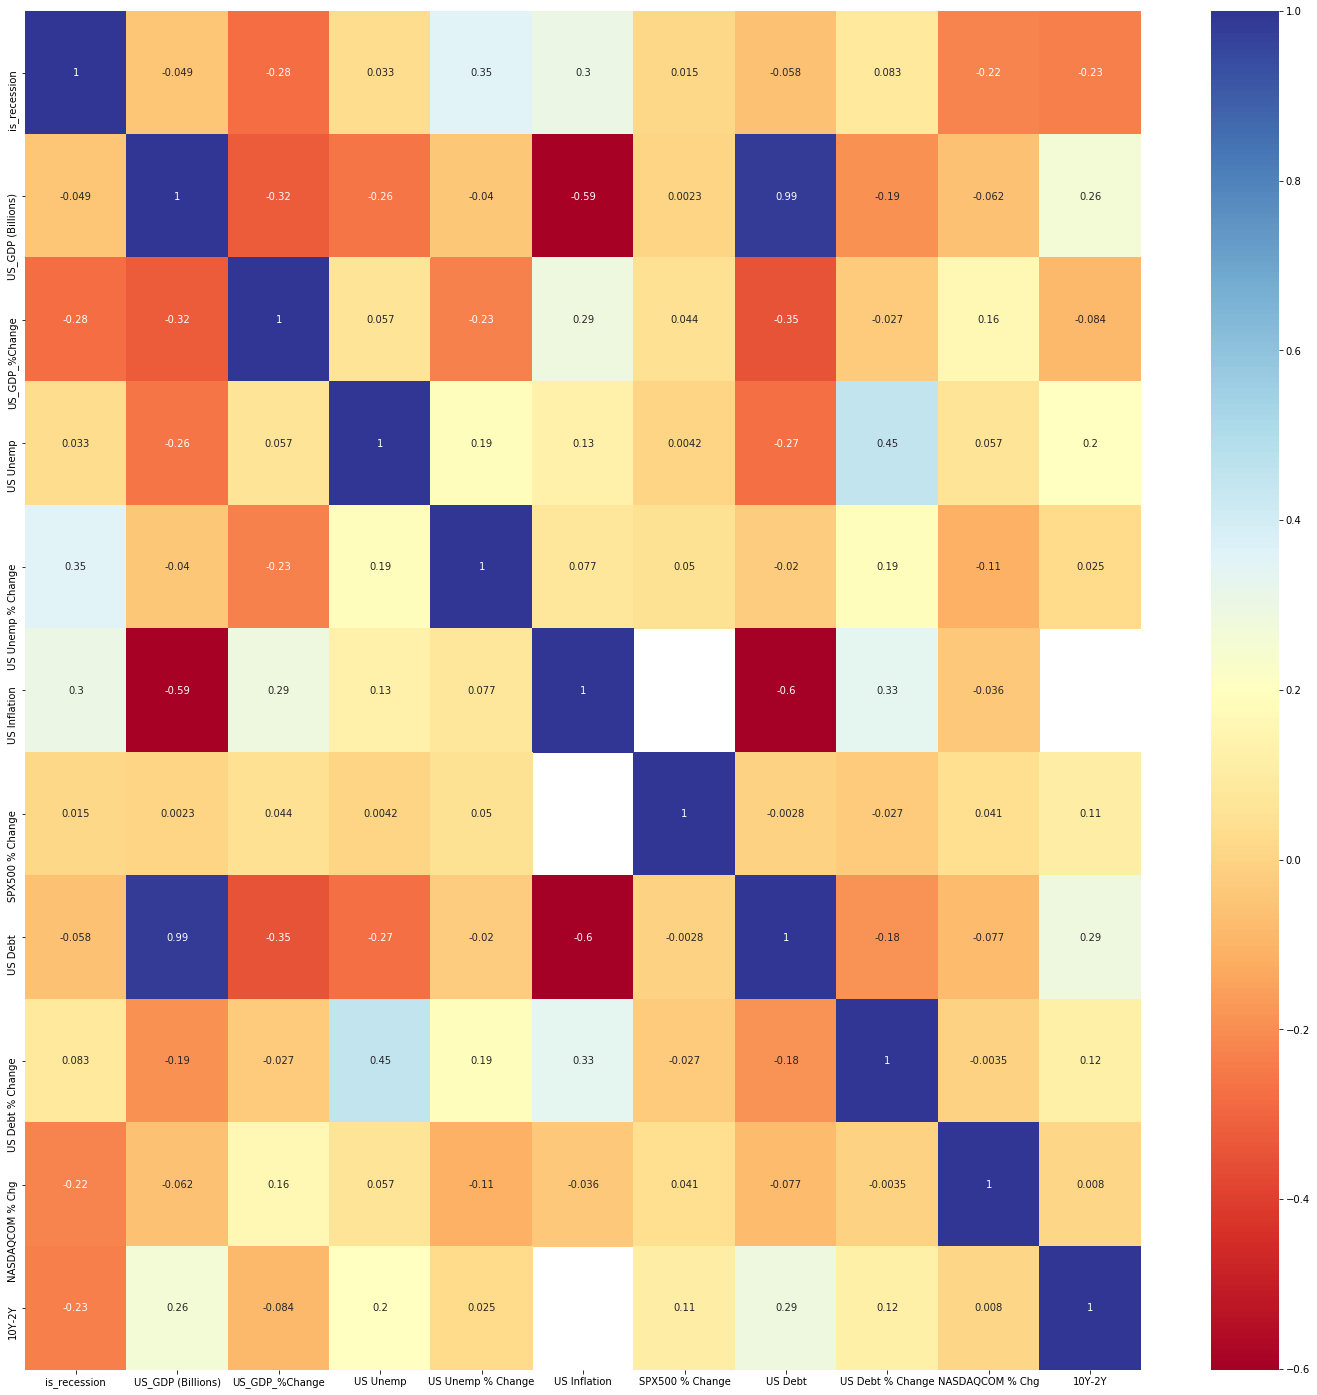

In [84]:
corr = df_merged.corr(method='kendall')
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True, cmap="RdYlBu")

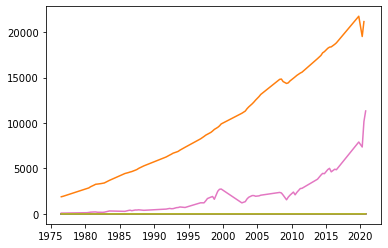

In [59]:
plt.plot(df_merged)

# Other Countries

In [379]:
us_data.drop(us_data.index, inplace=True)
us_recession = fred.get_series('JHDUSRGDPBR').loc['1970-01-01':].to_frame()
us_recession['isUSRecession'] = us_recession[0]
us_recession = us_recession.drop(columns = 0)

us_gdp = fred.get_series('GDP').loc['1970-01-01':].to_frame()
us_gdp['US_GDP (Billions)'] = us_gdp[0]
us_gdp = us_gdp.drop(columns = 0)

us_gdp_pctcg = fred.get_series('GDP').to_frame().pct_change().loc['1970-01-01':]
us_gdp_pctcg['US_GDP_%Change'] = us_gdp_pctcg[0]
us_gdp_pctcg = us_gdp_pctcg.drop(columns = 0)

unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]

q_sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today()).rename(columns = {'Adj Close' : "SPX500 % Change"})["SPX500 % Change"].pct_change()

us_data = pd.merge(us_recession,us_gdp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,us_gdp_pctcg, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,unemp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,q_sp500, how='inner', left_index=True, right_index=True)


japan_data.drop(japan_data.index, inplace=True)
japan_recession = fred.get_series('JPNRECP').loc['1970-01-01':].to_frame()
japan_recession['isJapanRecession'] = japan_recession[0]
japan_recession = japan_recession.drop(columns = 0)

japan_gdp = fred.get_series('JPNNGDP').loc['1970-01-01':'2019-10-01'].to_frame()
japan_gdp['Japan_GDP (Billions of Yen)'] = japan_gdp[0]
japan_gdp = japan_gdp.drop(columns = 0)

japan_data = pd.merge(japan_recession.iloc[::3, :],japan_gdp, how='outer', left_index=True, right_index=True)


UK_data.drop(UK_data.index, inplace=True)
UK_recession = fred.get_series('GBRRECDM').loc['1970-01-01':].to_frame()
UK_recession['isUKRecession'] = UK_recession[0]
UK_recession = UK_recession.drop(columns = 0)

UK_gdp = fred.get_series('UKNGDP').loc['1970-01-01':'2019-10-31'].to_frame()
UK_gdp['UK_GDP (Billions of Pounds)'] = UK_gdp[0]
UK_gdp = UK_gdp.drop(columns = 0)

UK_data = pd.merge(UK_recession.loc[UK_gdp.index], UK_gdp, how='outer', left_index=True, right_index=True)


china_data.drop(china_data.index, inplace=True)
china_recession = fred.get_series('CHNRECM').loc['1970-01-01':].to_frame()
china_recession['isChinaRecession'] = china_recession[0]
china_recession = china_recession.drop(columns = 0)
china_recession = china_recession.iloc[::12, :]

china_gdp = fred.get_series('MKTGDPCNA646NWDB').loc['1978-01-01':'2019-10-31'].to_frame()
china_gdp['China_GDP (Dollars)'] = china_gdp[0]
china_gdp = china_gdp.drop(columns = 0)

china_data = pd.merge(china_recession, china_gdp, how='outer', left_index=True, right_index=True)


euro_data.drop(euro_data.index, inplace=True)
euro_recession = fred.get_series('EUROREC').loc['1970-01-01':].to_frame()
euro_recession['isEuroRecession'] = euro_recession[0]
euro_recession = euro_recession.drop(columns = 0)

euro_gdp = fred.get_series('EUNNGDP').loc['1970-01-01':].to_frame()
euro_gdp['Euro_GDP (Millions of Euros)'] = euro_gdp[0]
euro_gdp = euro_gdp.drop(columns = 0)

euro_data = pd.merge(euro_recession.iloc[::3, :], euro_gdp.iloc[:-2], how='outer', left_index=True, right_index=True)


canada_data.drop(canada_data.index, inplace=True)
canada_recession = fred.get_series('CANRECDM').loc['1970-01-01':].to_frame()
canada_recession['isCanadaRecession'] = canada_recession[0]
canada_recession = canada_recession.drop(columns = 0)
canada_recession = canada_recession.loc[canada_gdp.index]

canada_gdp = fred.get_series('MKTGDPCAA646NWDB').loc['1970-01-01':].to_frame()
canada_gdp['Canada_GDP (Dollars)'] = canada_gdp[0]
canada_gdp = canada_gdp.drop(columns = 0)

canada_data = pd.merge(canada_recession, canada_gdp, how='outer', left_index=True, right_index=True)


india_data.drop(india_data.index, inplace=True)
india_recession = fred.get_series('INDREC').loc['1970-01-01':].to_frame().iloc[11:]
india_recession['isIndiaRecession'] = india_recession[0]
india_recession = india_recession.drop(columns = 0).iloc[::12, :]

india_gdp = fred.get_series('MKTGDPINA646NWDB').loc['1970-01-01':].to_frame()
india_gdp['India_GDP (Dollars)'] = india_gdp[0]
india_gdp = india_gdp.drop(columns = 0)

india_data = pd.merge(india_recession, india_gdp, how='outer', left_index=True, right_index=True)


germany_data.drop(germany_data.index, inplace=True)
germany_recession = fred.get_series('DEUREC').loc['1970-01-01':].to_frame()
germany_recession['isGermanyRecession'] = germany_recession[0]
germany_recession = germany_recession.drop(columns = 0).iloc[::12, :]

germany_gdp = fred.get_series('MKTGDPINA646NWDB').loc['1970-01-01':].to_frame()
germany_gdp['Germany_GDP (Dollars)'] = germany_gdp[0]
germany_gdp = germany_gdp.drop(columns = 0)

germany_data = pd.merge(germany_recession, germany_gdp, how='outer', left_index=True, right_index=True)


swiss_data.drop(swiss_data.index, inplace=True)
swiss_recession = fred.get_series('CHEREC').loc['1970-01-01':].to_frame()
swiss_recession['isSwissRecession'] = swiss_recession[0]
swiss_recession = swiss_recession.drop(columns = 0).iloc[::3, :]

swiss_gdp = fred.get_series('CPMNACSAB1GQCH').loc['1970-01-01':].to_frame()
swiss_gdp['Swiss_GDP (Dollars)'] = swiss_gdp[0]
swiss_gdp = swiss_gdp.drop(columns = 0)

swiss_data = pd.merge(swiss_recession, swiss_gdp, how='outer', left_index=True, right_index=True)


korea_data.drop(korea_data.index, inplace=True)
korea_recession = fred.get_series('KORRECD').loc['1970-01-01':].to_frame()
korea_recession['isKoreaRecession'] = korea_recession[0]
korea_recession = korea_recession.drop(columns = 0)

korea_gdp = fred.get_series('KORGDPNQDSMEI').loc['1970-01-01':].to_frame()
korea_gdp['Korea_GDP (Korean Won)'] = korea_gdp[0]
korea_gdp = korea_gdp.drop(columns = 0)

korea_data = pd.merge(korea_recession.loc[korea_gdp.index[:-3]], korea_gdp, how='outer', left_index=True, right_index=True)


aus_data.drop(aus_data.index, inplace=True)
aus_recession = fred.get_series('AUSRECM').loc['1970-01-01':].to_frame()
aus_recession['isAusRecession'] = aus_recession[0]
aus_recession = aus_recession.drop(columns = 0).iloc[::3, :]

aus_gdp = fred.get_series('AUSGDPNQDSMEI').loc['1970-01-01':].to_frame()
aus_gdp['Aus_GDP (Australian Dollars)'] = aus_gdp[0]
aus_gdp = aus_gdp.drop(columns = 0)

aus_data = pd.merge(aus_recession, aus_gdp, how='outer', left_index=True, right_index=True)


russia_data.drop(russia_data.index, inplace=True)
russia_recession = fred.get_series('RUSRECM').loc['1995-01-01':].to_frame()
russia_recession['isRussiaRecession'] = russia_recession[0]
russia_recession = russia_recession.drop(columns = 0).iloc[::12, :].dropna()

russia_gdp = fred.get_series('MKTGDPRUA646NWDB').loc['1970-01-01':].to_frame()
russia_gdp['Russia_GDP (US Dollars)'] = russia_gdp[0]
russia_gdp = russia_gdp.drop(columns = 0)

russia_data = pd.merge(russia_recession, russia_gdp, how='outer', left_index=True, right_index=True)



other_countries = [japan_data, UK_data, china_data, euro_data, canada_data, india_data, germany_data, swiss_data, korea_data, aus_data, russia_data]

In [380]:
# merge is the final combined DF of all countries
merge.drop(merge.index, inplace=True)
merge=pd.merge(us_data,japan_data, how='inner', left_index=True, right_index=True)
for i in other_countries[1:]:
    merge=pd.merge(merge,i, how='outer', left_index=True, right_index=True)

In [381]:
merge.to_excel('GDP_Recession_DF.xlsx')

In [382]:
merge

,isUSRecession,US_GDP (Billions),US_GDP_%Change,US Unemp,SPX500 % Change,isJapanRecession,Japan_GDP (Billions of Yen),isUKRecession,UK_GDP (Billions of Pounds),isChinaRecession,...,isGermanyRecession,Germany_GDP (Dollars),isSwissRecession,Swiss_GDP (Dollars),isKoreaRecession,Korea_GDP (Korean Won),isAusRecession,Aus_GDP (Australian Dollars),isRussiaRecession,Russia_GDP (US Dollars)
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13227.0,NaN,...,0.0,6.242248e+10,0.0,NaN,1.0,6.483000e+11,0.0,9.285000e+09,NaN,NaN
1970-04-01,1.0,1067.375,0.015387,4.6,0.004909,1.0,NaN,0.0,13805.0,NaN,...,NaN,NaN,0.0,NaN,1.0,6.575000e+11,1.0,9.642000e+09,NaN,NaN
1970-07-01,1.0,1086.059,0.017505,5.0,0.003025,1.0,NaN,0.0,14258.0,NaN,...,NaN,NaN,0.0,NaN,1.0,7.158000e+11,1.0,9.705000e+09,NaN,NaN
1970-10-01,1.0,1088.608,0.002347,5.5,0.000237,1.0,NaN,0.0,14765.0,NaN,...,NaN,NaN,0.0,NaN,1.0,7.750000e+11,1.0,9.867000e+09,NaN,NaN
1971-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,14981.0,NaN,...,1.0,6.735099e+10,0.0,NaN,1.0,8.095000e+11,1.0,1.024700e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,0.0,21329.877,0.010162,3.6,0.011569,0.0,555720.5,0.0,551860.0,NaN,...,NaN,NaN,1.0,181444.8,1.0,4.799356e+14,1.0,4.979670e+11,NaN,NaN
2019-07-01,0.0,21540.325,0.009866,3.7,0.007672,0.0,557755.8,0.0,557443.0,NaN,...,NaN,NaN,1.0,181870.5,0.0,4.814105e+14,1.0,5.035970e+11,NaN,NaN
2019-10-01,1.0,21747.394,0.009613,3.6,-0.012258,0.0,549625.6,0.0,557935.0,NaN,...,NaN,NaN,1.0,182349.1,NaN,4.845559e+14,1.0,5.024200e+11,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,178842.1,NaN,4.768053e+14,NaN,5.067790e+11,NaN,NaN


In [378]:
us_data.drop(us_data.index, inplace=True)
us_recession = fred.get_series('JHDUSRGDPBR').loc['1970-01-01':].to_frame()
us_recession['isUSRecession'] = us_recession[0]
us_recession = us_recession.drop(columns = 0)

us_gdp = fred.get_series('GDP').loc['1970-01-01':].to_frame()
us_gdp['US_GDP (Billions)'] = us_gdp[0]
us_gdp = us_gdp.drop(columns = 0)

us_gdp_pctcg = fred.get_series('GDP').to_frame().pct_change().loc['1970-01-01':]
us_gdp_pctcg['US_GDP_%Change'] = us_gdp_pctcg[0]
us_gdp_pctcg = us_gdp_pctcg.drop(columns = 0)

unemp = fred.get_series('UNRATE').loc['1970-01-01':].to_frame()
unemp['US Unemp'] = unemp[0]
unemp = unemp.drop(columns = 0).iloc[::3, :]

q_sp500 = pdr.get_data_yahoo('^GSPC', start='1970-01-01', end=date.today()).rename(columns = {'Adj Close' : "SPX500 % Change"})["SPX500 % Change"].pct_change()

us_data = pd.merge(us_recession,us_gdp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,us_gdp_pctcg, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,unemp, how='outer', left_index=True, right_index=True)
us_data = pd.merge(us_data,q_sp500, how='inner', left_index=True, right_index=True)
us_data

,isUSRecession,US_GDP (Billions),US_GDP_%Change,US Unemp,SPX500 % Change
1970-04-01,1.0,1067.375,0.015387,4.6,0.004909
1970-07-01,1.0,1086.059,0.017505,5.0,0.003025
1970-10-01,1.0,1088.608,0.002347,5.5,0.000237
1971-04-01,0.0,1156.271,0.018601,5.9,0.000798
1971-07-01,0.0,1177.675,0.018511,6.0,0.010942
...,...,...,...,...,...
2019-07-01,0.0,21540.325,0.009866,3.7,0.007672
2019-10-01,1.0,21747.394,0.009613,3.6,-0.012258
2020-04-01,0.0,19520.114,-0.094662,14.7,-0.044142
2020-07-01,NaN,21157.122,0.083863,10.2,0.005022
